In [1]:
import numpy as np
import scipy as sp
from scipy.optimize import fsolve, minimize, root

In [2]:
from torch import autograd
import torch

####################################################################################################
## example of "backward" from https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html ##
####################################################################################################

a = torch.tensor([2.], requires_grad=True)
b = torch.tensor([4.], requires_grad=True)

obj_fun = 3*a**3 - b**3
# c_eq = 0
c_eq = a**2-b**2
# c_ineq <= 0, to be transformed into bound constraints 
c_ineq = a*b # will be a*b + y = 0, y >= 0

lm_eq = 3
lm_ineq = 1

# transform ineq constraints into eq constraints
lm_bound = 1
slack = torch.tensor([2.], requires_grad=True)
c_ineq_slack = c_ineq + slack

L = obj_fun - lm_eq*torch.cat([c_eq, c_ineq_slack]) - lm_bound*slack
# def L(x, slack): return Q(x) - lm_eq*[c_eq + c_ineq] - lm_bound*slack

external_grad = torch.tensor([1., 1.])
L.backward(gradient=external_grad)

print(a.grad)
print(b.grad)
print(slack.grad)

tensor([48.])
tensor([-78.])
tensor([-5.])


In [3]:
# objective function
def obj_fun(x):
    # val = -1*(10*x[0]+8.4*x[1])

    val = (x[0]**2+(x[1]-5)**2)

    # val.requires_grad_()
    # val.retain_grad()
    # val = torch.sum(torch.square(x))s
    return val

# constraints of form g(x) = 0
def c_eq(x):
    # constr = x[0] - x[1] - 1
    constr = torch.zeros(1,dtype=torch.float64)
    # constr.requires_grad_()
    if constr.ndim == 0:
        constr = constr.unsqueeze(dim=0)
    # constr.retain_grad()
    return constr

# constraints of form g(x) <= 0
def c_ineq(x):
    # constr = torch.cat([
    #     (2*x[0] + 3*x[1] - 34).reshape(1),
    #     (3*x[0] + 5*x[1] - 54).reshape(1)
    # ])
    constr = torch.cat([
        (-2*x[0] - x[1] + 4).reshape(1),
        1*x[0].reshape(1),
        1*x[1].reshape(1)
    ])
        
    # constr.retain_grad()
    # constr = torch.zeros(m_ineq, dtype=torch.float64)
    return constr

# def zero_relu(x):
#     res = torch.zeros_like(x)
#     for i, x_elem in enumerate(x):
#         res[i] = x_elem if x_elem <= 0 else 0
#     return res
            

def lagr(x, l_eq, l_ineq):
    eq_val = c_eq(x)
    ineq_val = c_ineq(x)
    val = obj_fun(x) + l_eq @ eq_val + l_ineq @ torch.relu(ineq_val)
    # val = obj_fun(x) + l_eq @ eq_val + l_ineq @ zero_relu(ineq_val)
    # val.requires_grad_()
    # val.retain_grad()
    return val

def lagr_univar(z, n, m_eq):
    x, l_eq, l_ineq = torch.tensor_split(z, (n, n+m_eq))
    return lagr(x, l_eq, l_ineq)

# def lagr_grad(x, l_eq, l_ineq):
#     external_grad = torch.tensor(1.)
#     L = lagr(x, l_eq, l_ineq)
#     # L.retain_grad()
#     L.backward(gradient=external_grad)
#     return x.grad, l_eq.grad, l_ineq.grad

# def lagr_grad_univar(z, n):
#     x, l_eq, l_ineq = torch.tensor_split(z, [n, n+m_eq])
#     # x.retain_grad()
#     # l_eq.retain_grad()
#     # l_ineq.retain_grad()
#     L = lagr(x, l_eq, l_ineq)
#     external_grad = torch.tensor(1.)
#     L.backward(gradient=external_grad)
#     # x_grad, l_eq_grad, l_ineq_grad = obj_grad(x, l_eq, l_ineq)
#     return z.grad

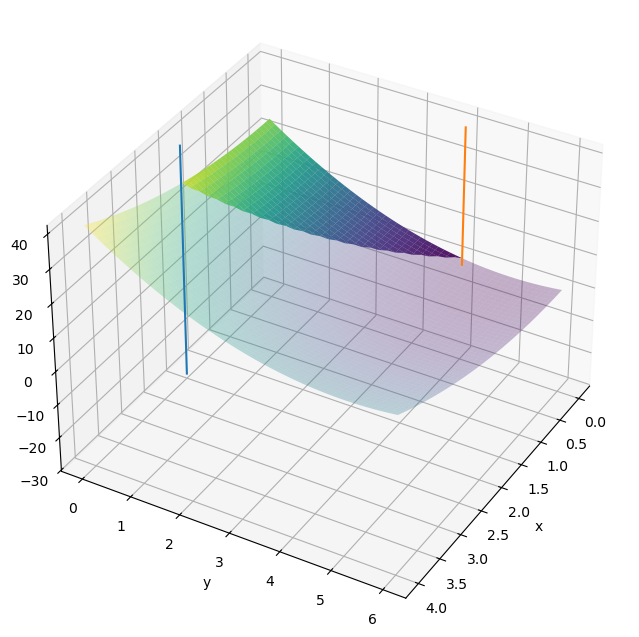

In [4]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Define grid for x and y
x = np.linspace(0, 4, 100)
y = np.linspace(0, 6, 100)
X, Y = np.meshgrid(x, y)

Z = X**2 + (Y - 5)**2
constraint = 2 * X + Y <= 4

Z_masked = np.where(constraint, Z, np.nan)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z_masked, cmap='viridis', edgecolor='none', alpha=0.9,zorder=-1)
ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.3,zorder=-1)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax.view_init(35, 30, 0)
ax.plot([2, 2], [0,0], [-1*obj_fun([2,0]), 40],zorder=10)
ax.plot([0, 0], [4,4], [-1*obj_fun([0,4]), 40],zorder=10)

plt.show()

***
Working with autograd functional api (much nicer):

In [5]:
n = 2
m_eq = 1
m_ineq = 3

x = torch.ones(n+m_eq+m_ineq, dtype=torch.float64)

In [6]:
def lagr_autojac_wrapper(z):
    if not isinstance(z, torch.Tensor):
        z = torch.tensor(z,dtype=torch.float64)
    return torch.autograd.functional.jacobian(lambda x: lagr_univar(x,n, m_eq), z).numpy()

def lagr_autohess_wrapper(z):
    if not isinstance(z, torch.Tensor):
        z = torch.tensor(z,dtype=torch.float64)
    return torch.autograd.functional.hessian(lambda x: lagr_univar(x, n, m_eq), z).numpy()

print(lagr_autojac_wrapper(x))
print(lagr_autohess_wrapper(x))

[ 1. -8.  0.  1.  1.  1.]
[[ 2.  0.  0. -2.  1.  0.]
 [ 0.  2.  0. -1.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.]
 [-2. -1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.]]


***
Try to find roots of the (auto)gradient of the lagrangian

In [7]:
# find a root of gradient (jacobian) of lagrangian

sol = root(lagr_autojac_wrapper, x0=torch.ones(n+m_eq+m_ineq,dtype=torch.float64),# jac=lagr_autohess_wrapper,
           method='krylov', options={'maxiter': 1000, 'xtol':1e-9})

print(sol)
print('\n ------\n')
print(f"x = {sol['x']}")
print(f"obj. fun. at x = {obj_fun(sol['x'][:n])}")
print(f"jac. of lagr. at x = {sol['fun']}")
print(f"c_ineq at x = {c_ineq(torch.tensor(sol['x']))}")

 message: The maximum number of iterations allowed has been reached.
 success: False
  status: 2
     fun: [-5.107e-01 -2.896e-01  0.000e+00  0.000e+00  8.111e-01
            2.510e+00]
       x: [ 8.111e-01  2.510e+00  1.000e+00  2.307e+03 -2.133e+00
            4.691e+00]
     nit: 1000
  method: krylov
    nfev: 3171

 ------

x = [ 8.11141556e-01  2.50960035e+00  1.00000000e+00  2.30672550e+03
 -2.13293531e+00  4.69124053e+00]
obj. fun. at x = 6.860041027965168
jac. of lagr. at x = [-0.5106522  -0.28955876  0.          0.          0.81114156  2.50960035]
c_ineq at x = tensor([-0.1319,  0.8111,  2.5096], dtype=torch.float64)


In [8]:
# x = torch.tensor([2.,0.,0.,2.,0.,12.])
x = torch.ones(n+m_eq+m_ineq)
ineq_val = c_ineq(x)

l_ineq = x[3:]
print(torch.autograd.functional.jacobian(lambda x: torch.relu(c_ineq(x)), x))
# print(torch.autograd.functional.jacobian(lambda x: obj_fun(x) + l_ineq @ zero_relu(c_ineq(x)), x))
# print(torch.autograd.functional.jacobian(obj_fun, x))
# print(torch.autograd.functional.jacobian(lambda x: l_ineq @ zero_relu(c_ineq(x)), x))

tensor([[-2., -1.,  0.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  1.,  0.,  0.,  0.,  0.]])


In [9]:
# find roots of gradient (jacobian) of lagrangian
from scipy.optimize import fsolve

sol = fsolve(lagr_autojac_wrapper, x0=torch.zeros(n+m_eq+m_ineq,dtype=torch.float64), fprime=lagr_autohess_wrapper,
             xtol=1e-15)
print(sol)
print(obj_fun(sol))

SyntaxError: incomplete input (772105763.py, line 7)

***
Try to use scipy.minimize with autograd jacobian and hessian (unsuccessful so far):

In [132]:
def c_ineq_eq(x):
    constr = torch.cat([
        (2*x[0] + x[1] - 4).reshape(1),
        -1*x[0].reshape(1),
        -1*x[1].reshape(1)
    ])
    return torch.max(torch.zeros_like(constr,dtype=torch.float64), constr)

In [166]:
def constr_autojac(x):
    return torch.autograd.functional.jacobian(c_ineq_eq, torch.tensor(x,dtype=torch.float64),create_graph=True).numpy()

def constr_autohess(x, v):
    return torch.autograd.functional.hessian(lambda x: c_ineq_eq(x) @ torch.tensor(v,dtype=torch.float64), torch.tensor(x,dtype=torch.float64)).numpy()

print(constr_autojac([1.,1.,1.]))
print(constr_autohess([1.,1.,1.], [1.,1.,1.]))

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


In [ ]:
from scipy.optimize import NonlinearConstraint

x0=torch.zeros(n,dtype=torch.float64)

c = NonlinearConstraint(lambda x: c_ineq_eq(torch.tensor(x)), lb=torch.tensor([4.,0.,0.]), ub=torch.tensor([4.,0.,0.]), jac=constr_autojac, hess=constr_autohess)

# res = minimize(obj_fun, x0=x0, jac=lambda x: torch.tensor([2.*x[0], 2.*x[1]-10.]), constraints=[c],method='SLSQP')


res = minimize(obj_fun, x0=x0, jac=lambda x: torch.tensor([2.*x[0], 2.*x[1]-10.]),
               constraints=[{'type':'eq','fun':lambda x: c_ineq_eq(torch.tensor(x)),'jac':constr_autojac}],method='trust-constr')

res